In [33]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score, hamming_loss

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [7]:
def evaluate_multilabel_classification(lst, df, RNN=False):
    plt.figure(figsize=(15,20))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

## Baseline: One Versus Rest with LR

In [8]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


In [9]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [10]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [11]:
# accuracy across labels
accuracy_score(y_test, ovr_test_preds)

0.20766773162939298

In [13]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.33203125
disgust_label precision: 0.6390977443609023
disgust_label recall 0.5985915492957746
disgust_label f1 0.6181818181818183


fear_label accuracy: 0.6389891696750902
fear_label precision: 0.8009049773755657
fear_label recall 0.8309859154929577
fear_label f1 0.815668202764977


joy_label accuracy: 0.5384615384615384
joy_label precision: 0.7368421052631579
joy_label recall 0.7253886010362695
joy_label f1 0.7310704960835509


sadness_label accuracy: 0.6819787985865724
sadness_label precision: 0.8109243697478992
sadness_label recall 0.8654708520179372
sadness_label f1 0.8373101952277657


surprise_label accuracy: 0.8900343642611683
surprise_label precision: 0.9184397163120568
surprise_label recall 0.9217081850533808
surprise_label f1 0.9200710479573712




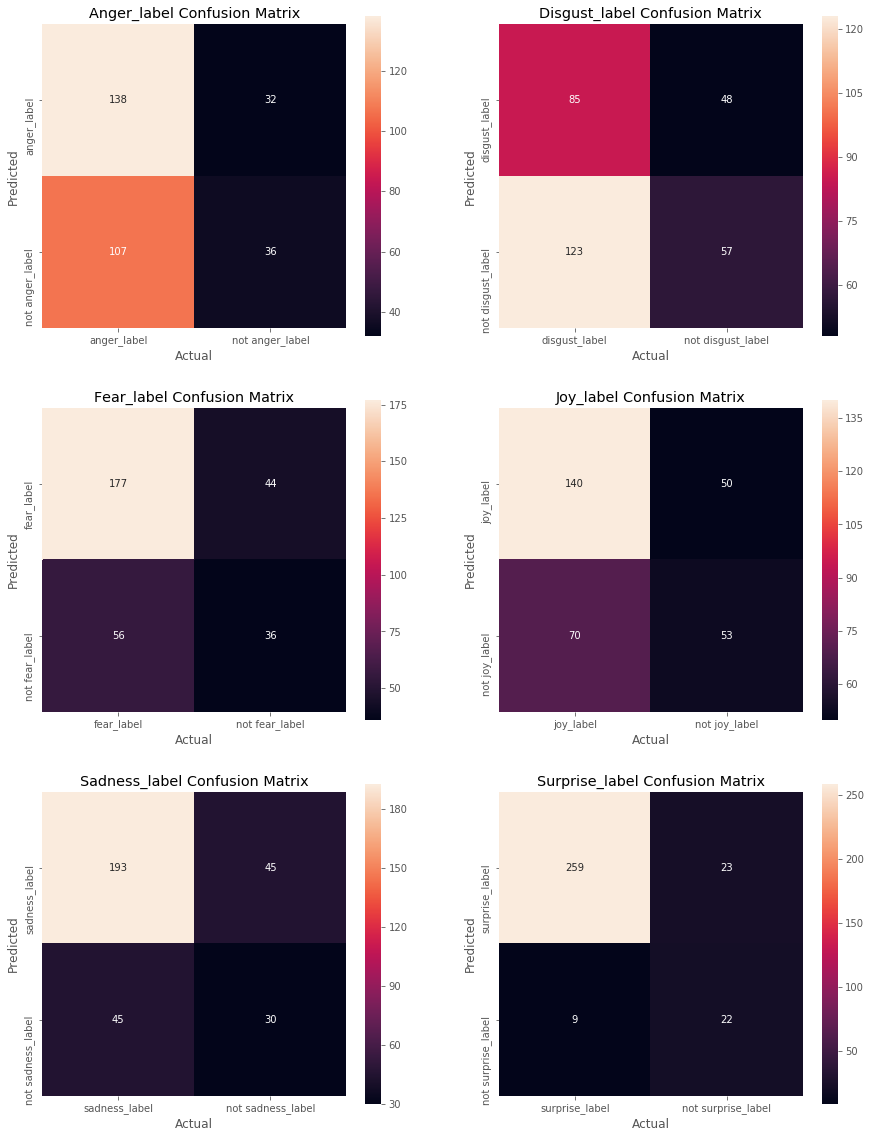

In [14]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [15]:
jaccard_score_samples = jaccard_score(y_test, ovr_test_preds, average='samples')
jaccard_score_weighted = jaccard_score(y_test, ovr_test_preds, average='weighted')
hamming_loss_score = hamming_loss(y_test, ovr_test_preds)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)

jaccard score average: 0.6845047923322684
jaccard score weighted: 0.6835050775882321
hamming loss: 0.2534611288604899


## Classifier Chain

In [16]:
import itertools
from sklearn.metrics import jaccard_score

np.random.seed=42
perms = list(itertools.permutations([0,1,2,3,4,5]))
random = np.random.choice(len(perms), size=720,)
perms_to_try = [perms[i] for i in random]

chains = [ClassifierChain(lr, order=perms_to_try[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [18]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.6960596379126731

In [19]:
# cc_train_preds = chains[results.index(max(results_jaccard))].predict(tf_idf_X_train)
# cc_test_preds = chains[results.index(max(results_jaccard))].predict(tf_idf_X_test)


In [20]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.35471698113207545
disgust_label precision: 0.6666666666666666
disgust_label recall 0.6619718309859155
disgust_label f1 0.6643109540636043


fear_label accuracy: 0.6415770609318996
fear_label precision: 0.8364485981308412
fear_label recall 0.8403755868544601
fear_label f1 0.8384074941451991


joy_label accuracy: 0.5402298850574713
joy_label precision: 0.7540106951871658
joy_label recall 0.7305699481865285
joy_label f1 0.7421052631578948


sadness_label accuracy: 0.6727272727272727
sadness_label precision: 0.8371040723981901
sadness_label recall 0.8295964125560538
sadness_label f1 0.8333333333333333


surprise_label accuracy: 0.8869257950530035
surprise_label precision: 0.916058394160584
surprise_label recall 0.8932384341637011
surprise_label f1 0.9045045045045046




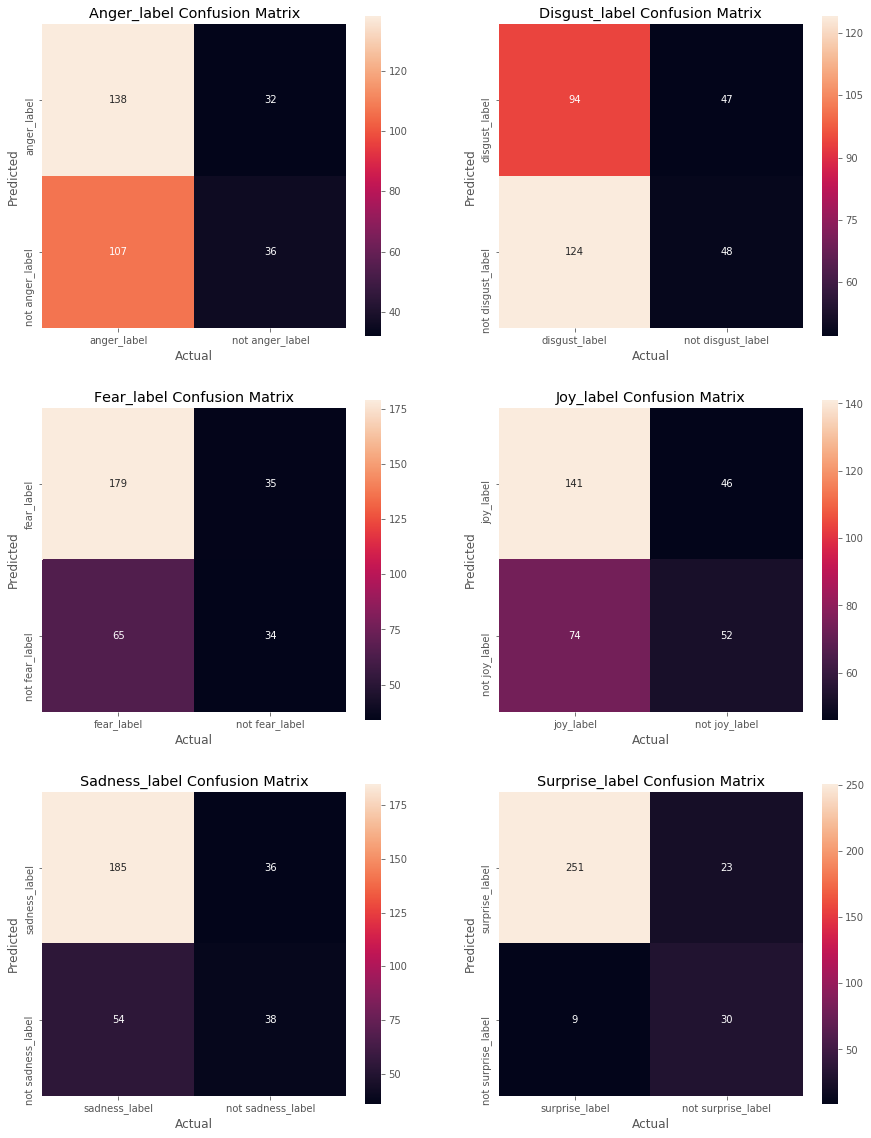

In [21]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [24]:
jaccard_score_samples = jaccard_score(y_test, cc_test_preds.toarray(), average='samples')
jaccard_score_weighted = jaccard_score(y_test, cc_test_preds.toarray(), average='weighted')
hamming_loss_score = hamming_loss(y_test, cc_test_preds.toarray())
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)

jaccard score average: 0.6960596379126731
jaccard score weighted: 0.6901165220548294
hamming loss: 0.24334398296059637


## Label Power Emotion Labels

In [97]:
lp = LabelPowerset(lr)

lp.fit(tf_idf_X_train, y_train)
lp_train_preds = lp.predict(tf_idf_X_train)
lp_test_preds = lp.predict(tf_idf_X_test)

In [98]:
LP_preds_df = pd.DataFrame(lp_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [99]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,0,1,0,1,0,0,1,1,1,1
1,1,1,1,1,1,1,0,0,1,1,1,1
2,1,1,1,0,1,1,0,0,1,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0,1
4,1,1,0,1,1,1,1,1,1,1,1,1


anger_label accuracy: 0.430327868852459
anger_label precision: 0.6325301204819277
anger_label recall 0.603448275862069
anger_label f1 0.6176470588235294


disgust_label accuracy: 0.27848101265822783
disgust_label precision: 0.5365853658536586
disgust_label recall 0.4647887323943662
disgust_label f1 0.4981132075471698


fear_label accuracy: 0.6138996138996139
fear_label precision: 0.7227272727272728
fear_label recall 0.7464788732394366
fear_label f1 0.7344110854503464


joy_label accuracy: 0.5238095238095238
joy_label precision: 0.6700507614213198
joy_label recall 0.6839378238341969
joy_label f1 0.676923076923077


sadness_label accuracy: 0.6442687747035574
sadness_label precision: 0.7616822429906542
sadness_label recall 0.7309417040358744
sadness_label f1 0.745995423340961


surprise_label accuracy: 0.8865248226950354
surprise_label precision: 0.8865248226950354
surprise_label recall 0.8896797153024911
surprise_label f1 0.8880994671403197




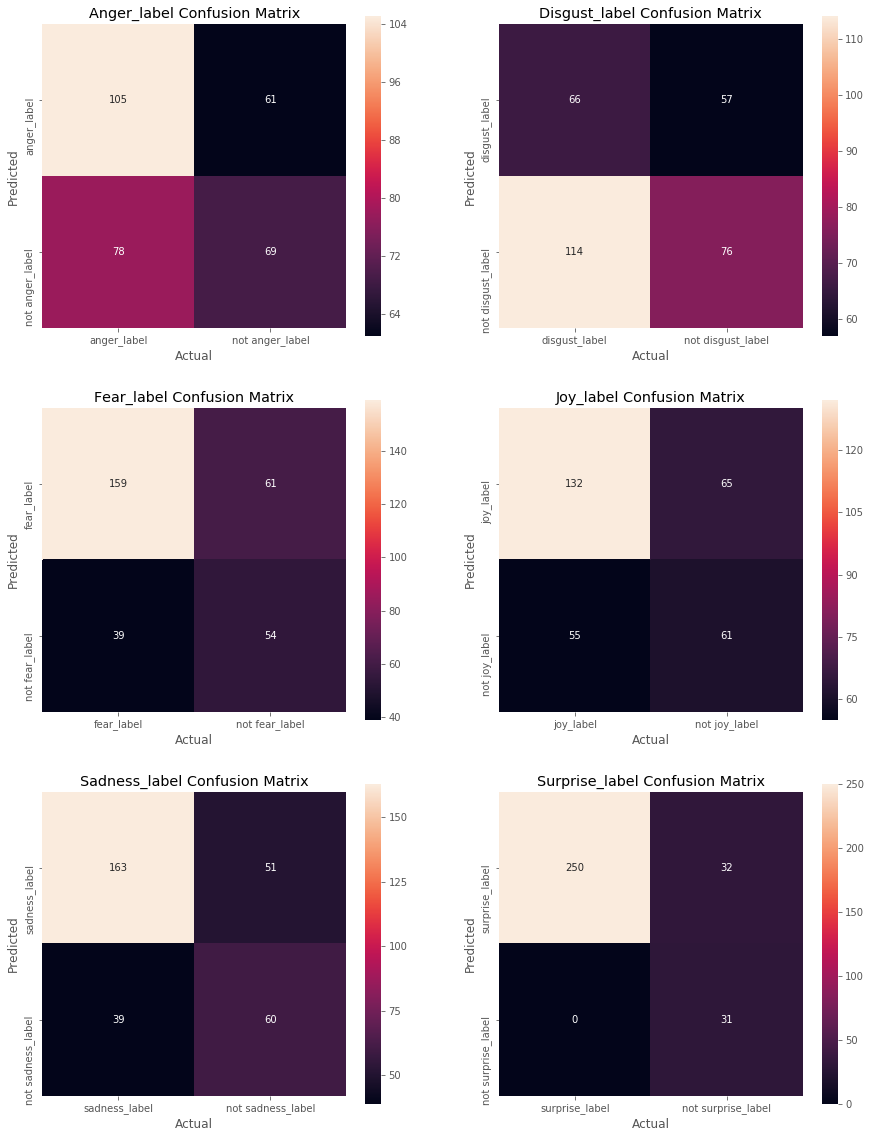

In [100]:
evaluate_multilabel_classification(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


In [101]:
jaccard_score_samples = jaccard_score(y_test, lr_test_preds, average='samples')
jaccard_score_weighted = jaccard_score(y_test, lr_test_preds, average='weighted')
hamming_loss_score = hamming_loss(y_test, lr_test_preds)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)


jaccard score average: 0.5261448349307775
jaccard score weighted: 0.5274285384225336
hamming loss: 0.4164004259850905


## RNN for Multilabel Classification

In [102]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [75]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [76]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [77]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=42)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [91]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 9s 9ms/step - loss: 0.6905 - acc: 0.6124 - val_loss: 0.6047 - val_acc: 0.6976
Epoch 2/30
937/937 [==============================] - 0s 383us/step - loss: 0.4960 - acc: 0.7670 - val_loss: 0.6003 - val_acc: 0.7013
Epoch 3/30
937/937 [==============================] - 0s 389us/step - loss: 0.4183 - acc: 0.8278 - val_loss: 0.5634 - val_acc: 0.7322
Epoch 4/30
937/937 [==============================] - 0s 386us/step - loss: 0.3549 - acc: 0.8735 - val_loss: 0.5374 - val_acc: 0.7524
Epoch 5/30
937/937 [==============================] - 0s 386us/step - loss: 0.2980 - acc: 0.9059 - val_loss: 0.5338 - val_acc: 0.7529
Epoch 6/30
937/937 [==============================] - 0s 402us/step - loss: 0.2530 - acc: 0.9310 - val_loss: 0.5343 - val_acc: 0.7487
Epoch 7/30
937/937 [==============================] - 0s 403us/step - loss: 0.2111 - acc: 0.9502 - val_loss: 0.5396 - val_acc: 0.7572
Epoch 8/30
937/937

313/313 [==============================] - 0s 245us/step


[0.6480079194227346, 0.7428115067390588]

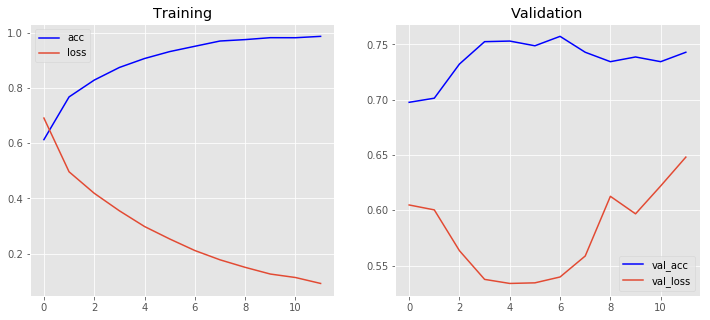

In [93]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [94]:
model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.44609665427509293
anger precision: 0.7843137254901961
anger recall 0.7317073170731707
anger f1 0.7570977917981072


disgust accuracy: 0.35447761194029853
disgust precision: 0.6597222222222222
disgust recall 0.6785714285714286
disgust f1 0.6690140845070424


fear accuracy: 0.6033898305084746
fear precision: 0.7063492063492064
fear recall 0.9081632653061225
fear f1 0.7946428571428572


joy accuracy: 0.5525291828793775
joy precision: 0.7553191489361702
joy recall 0.7171717171717171
joy f1 0.7357512953367876


sadness accuracy: 0.6517241379310345
sadness precision: 0.8042553191489362
sadness recall 0.8915094339622641
sadness f1 0.8456375838926175


surprise accuracy: 0.8847457627118644
surprise precision: 0.8938356164383562
surprise recall 0.9354838709677419
surprise f1 0.9141856392294221




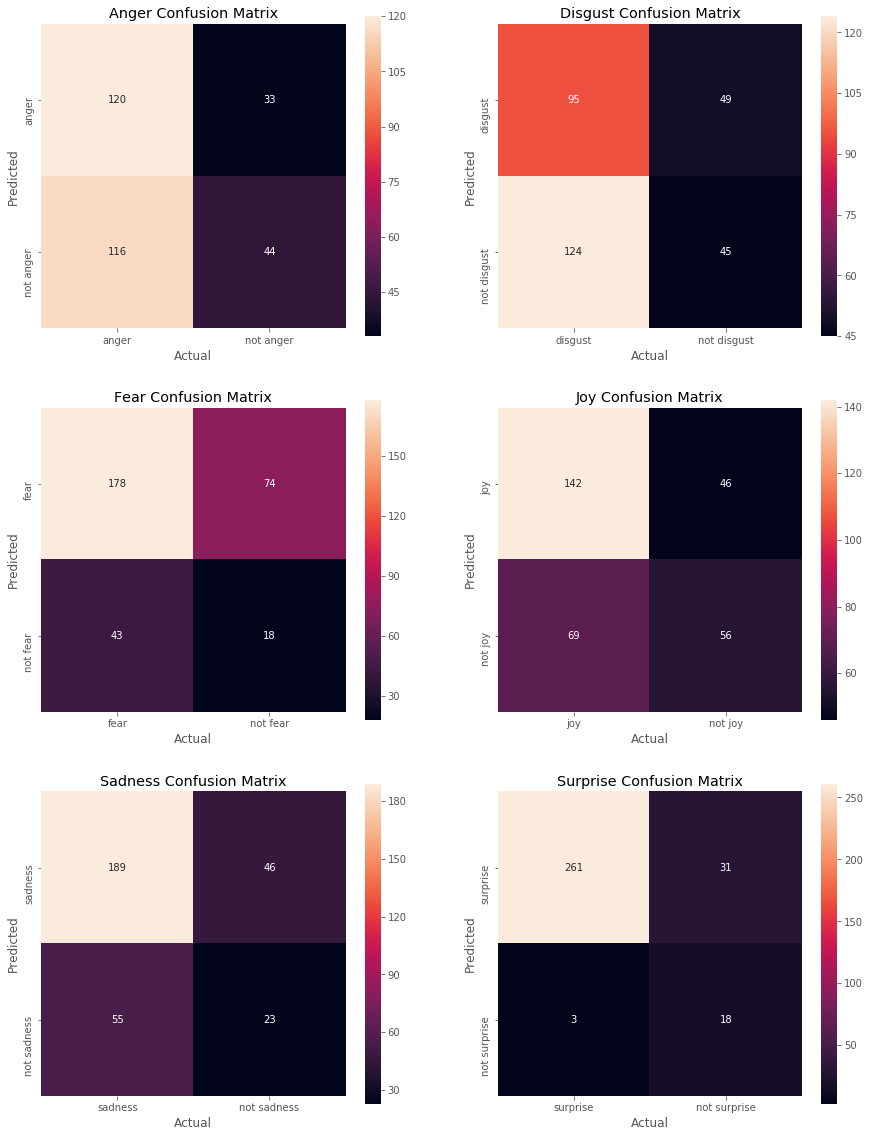

In [95]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [96]:
jaccard_score_samples = jaccard_score(y_test, RNN_preds>.5, average='samples')
jaccard_score_weighted = jaccard_score(y_test, RNN_preds>.5, average='weighted')
hamming_loss_score = hamming_loss(y_test, RNN_preds>.5)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)

jaccard score average: 0.6819488817891374
jaccard score weighted: 0.676968457628816
hamming loss: 0.2571884984025559
